<a href="https://colab.research.google.com/github/katragadda-navya/Fake-News-Detection/blob/main/DataMining_Project_Fake_News_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

file_path = '/content/WELFake_Dataset.csv'

df = pd.read_csv(file_path, on_bad_lines='skip', engine='python')
df.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [ ]:
df = df.drop(["Unnamed: 0"], axis=1)
df=df.fillna(' ')
df['total']=df['title']+' '+df['text']
df = df.drop(["title", "text", "index"], axis = 1)
df = df[df['label'].isin(['0', '1'])]
df.isnull().sum()

,0
label,0
total,0


In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(df['label'])
df['label'] = le.transform(df['label'])
df.head()

,label,total
0,1,LAW ENFORCEMENT ON HIGH ALERT Following Threat...
1,1,Did they post their votes for Hillary already?
2,1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...
3,0,"Bobby Jindal, raised Hindu, uses story of Chri..."
4,1,SATAN 2: Russia unvelis an image of its terrif...


In [ ]:
df = df.sample(frac=1)
df.reset_index(inplace=True)

<Axes: xlabel='label', ylabel='count'>

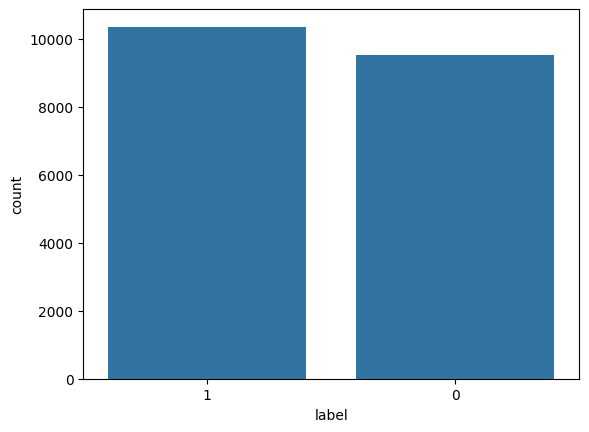

In [ ]:
import seaborn as sns
sns.countplot(data=df,
              x='label',
              order=df['label'].value_counts().index)

In [ ]:
from tqdm import tqdm
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#remove all the stopwords, punctuations and any irrelevant spaces from the text
def preprocess_text(text_data):
    preprocessed_text = []

    for sentence in tqdm(text_data):
        sentence = re.sub(r'[^\w\s]', '', sentence)
        preprocessed_text.append(' '.join(token.lower()
                                  for token in str(sentence).split()
                                  if token not in stopwords.words('english')))

    return preprocessed_text

In [ ]:
preprocessed_review = preprocess_text(df['total'].values)
df['total'] = preprocessed_review

100%|██████████| 19891/19891 [10:18<00:00, 32.15it/s]


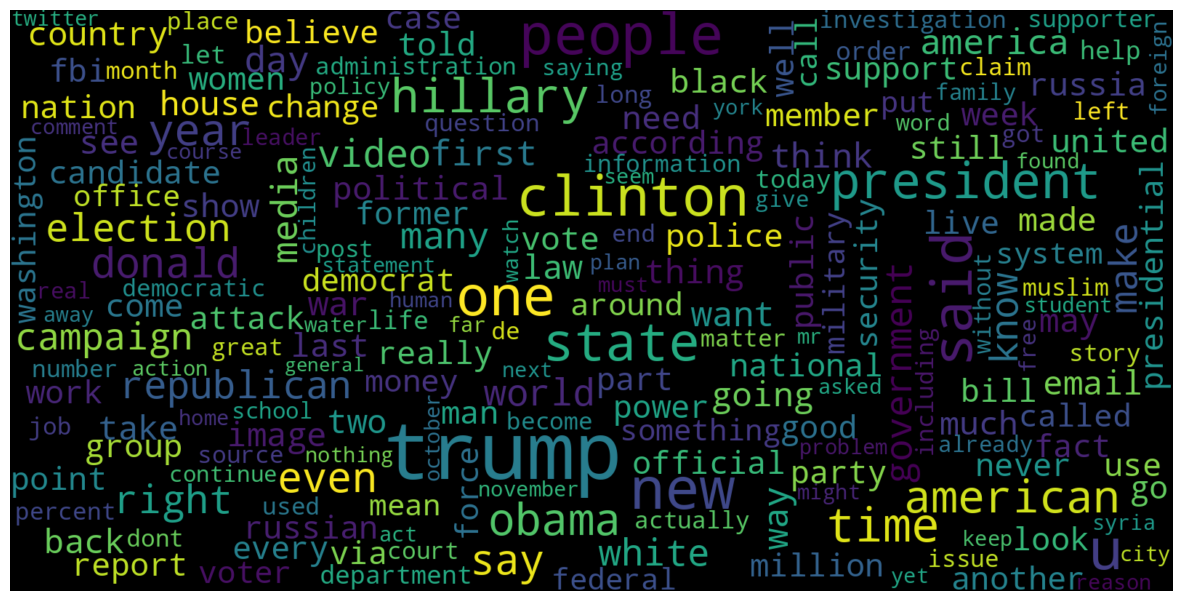

In [ ]:
import matplotlib.pyplot as plt
#real
consolidated = ' '.join(
    word for word in df['total'][df['label'] == 1].astype(str))
wordCloud = WordCloud(width=1600,
                      height=800,
                      random_state=21,
                      max_font_size=110,
                      collocations=False)
plt.figure(figsize=(15, 10))
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')
plt.axis('off')
plt.show()

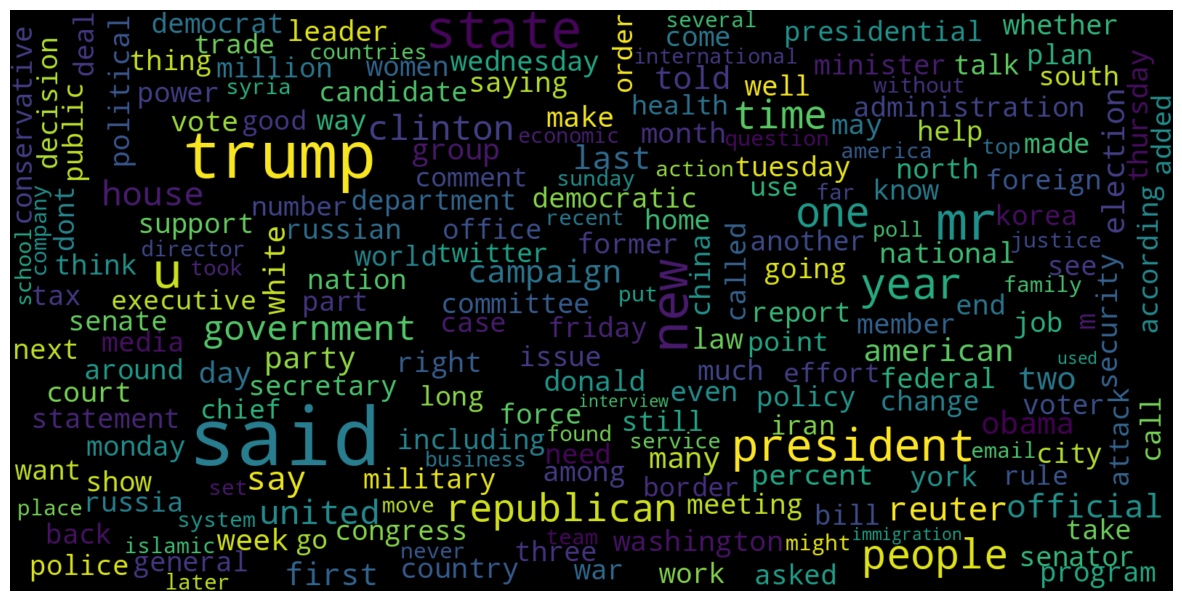

In [ ]:
# Fake
consolidated = ' '.join(
    word for word in df['total'][df['label'] == 0].astype(str))
wordCloud = WordCloud(width=1600,
                      height=800,
                      random_state=21,
                      max_font_size=110,
                      collocations=False)
plt.figure(figsize=(15, 10))
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')
plt.axis('off')
plt.show()

<Axes: title={'center': 'Bar Chart of Top Words Frequency'}, xlabel='Top Words', ylabel='Count'>

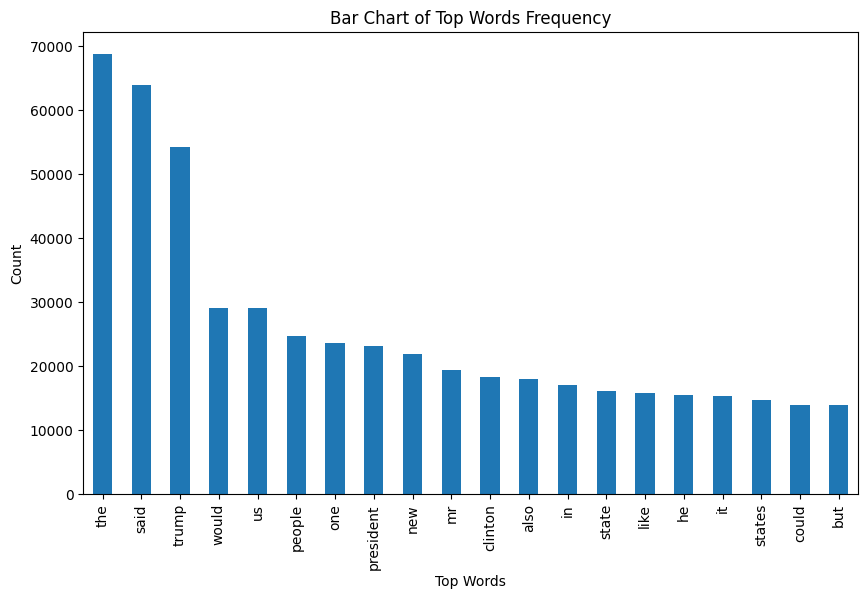

In [ ]:
#bargraph of the top 20 most frequent words
from sklearn.feature_extraction.text import CountVectorizer


def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1],
                        reverse=True)
    return words_freq[:n]


common_words = get_top_n_words(df['total'], 20)
df1 = pd.DataFrame(common_words, columns=['Review', 'count'])

df1.groupby('Review').sum()['count'].sort_values(ascending=False).plot(
    kind='bar',
    figsize=(10, 6),
    xlabel="Top Words",
    ylabel="Count",
    title="Bar Chart of Top Words Frequency"
)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

x_train, x_test, y_train, y_test = train_test_split(df['total'],
                                                    df['label'],
                                                    test_size=0.25)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorization = TfidfVectorizer()
x_train = vectorization.fit_transform(x_train)
x_test = vectorization.transform(x_test)

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(x_train, y_train)

# testing the model
print(accuracy_score(y_train, model.predict(x_train)))
print(accuracy_score(y_test, model.predict(x_test)))

0.9698350985386781
0.9422883571284939


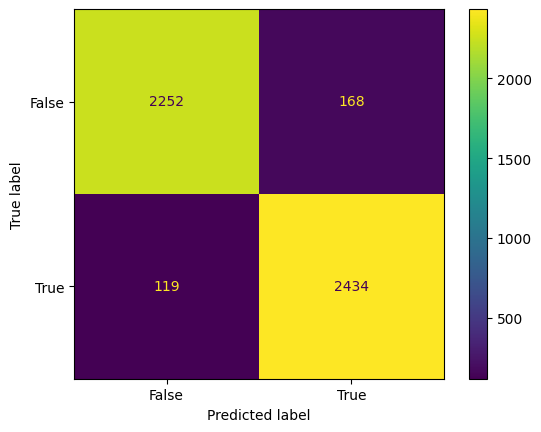

In [ ]:
from sklearn import metrics
cm = metrics.confusion_matrix(y_test, model.predict(x_test))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                                            display_labels=[False, True])

cm_display.plot()
plt.show()

In [ ]:
from sklearn import svm
# Classifier - Support Vector Machine
SVM = svm.SVC(C=1.9, kernel='linear')
SVM.fit(x_train, y_train)

0.9698350985386781
0.9422883571284939


0.9982571390266792
0.9617936859038809


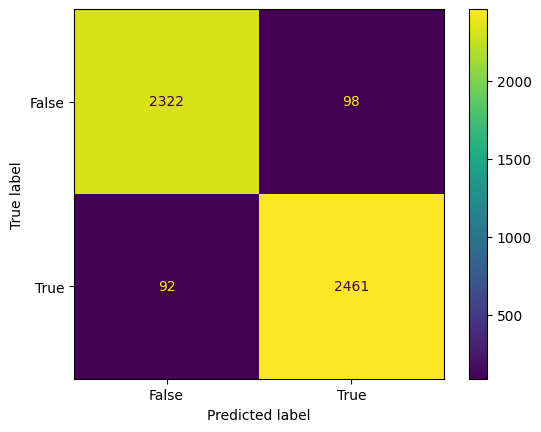

In [ ]:
print(accuracy_score(y_train, SVM.predict(x_train)))
print(accuracy_score(y_test, SVM.predict(x_test)))
cm = metrics.confusion_matrix(y_test, SVM.predict(x_test))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                                            display_labels=[False, True])

cm_display.plot()
plt.show()